# Manipulating the components of the NILM pipeline

The main goal of deep-NILMtk is to facilitate the implementation of NILM pipelines and to make it easier for scholars
to explore different setups using minimal coding. This would not only allow fast prototyping but also enhance reproducibility and transparency in research. The code sharing and
The implemented pipeline is illustarted in the figure bellow

In [1]:
from deep_nilmtk.models.pytorch import UNETNILM
from deep_nilmtk.data.loader.pytorch import GeneralDataLoader
from deep_nilmtk.utils import setup
from deep_nilmtk.disaggregator import NILMExperiment
from deep_nilmtk.data.pre_process import preprocess 
from nilmtk import DataSet

from deep_nilmtk.utils.templates import ExperimentTemplate

import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [ ]:
max_nb_epochs = 20
sequence_length = 121

DATA_PATH = '../../data/ukdale.h5'
EXPERIMENT_NAME = 'unet_cutom_preprocessing'
RESULTS_PATH = '../../unet_cutom_preprocessing'

## Exploratory data analysis

In [3]:
wm_data  = DataSet(DATA_PATH)
wm_data.set_window(start='2015-01-04',  end='2015-03-30')
df_wm = next(wm_data.buildings[1].elec['washing machine'].load())
df_main = next(wm_data.buildings[1].elec.mains().load())

**Checking the available measurements**

In [4]:
df_main.columns

MultiIndex([(  'power', 'apparent'),
            ('voltage',         ''),
            (  'power',   'active')],
           names=['physical_quantity', 'type'])

In [5]:
df_wm.columns

MultiIndex([('power', 'active')],
           names=['physical_quantity', 'type'])

So for this first building we have three measurements for the aggregate power and only the active power can be used as target power. We will restrict our experiments to using only the active power in both input and output.

In [6]:
df_main.columns = ['voltage', 'apparent_power', 'active_power']
df_wm.columns = ['active_power']

**The rate of NaN values in the dataset**

In [9]:
df_wm['active_power'].isnull().mean()

0.0

In [10]:
df_wm['active_power'].isnull().mean()

0.0

**The values distribution**

To check the distribution, we will not account for the 0's included in the dataset. We are also aware that the washing machine is big consumer and tehrefore we will filter small value that most probably noise related to measurement devices.

Text(0.5, 1.0, 'Power consumption levels of the washing machine')

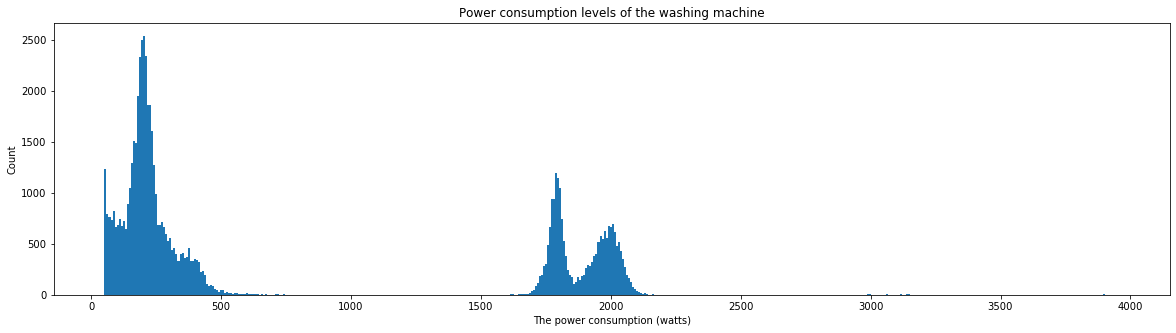

In [11]:
figure(figsize=(20,5))
_ = plt.hist(df_wm['active_power'].values[df_wm['active_power'].values>50], bins=500)
plt.xlabel('The power consumption (watts)')
plt.ylabel('Count')
plt.title('Power consumption levels of the washing machine')

The previous plot show that the power consumption of the washing machine form this first building is centered around three different operation states. This is information is not new as we know that the washing mahcien is multi-state appliance. However, the plot also shows that the power series contains some outliers which are values greater than 2500 watts. Let's keep this in mind to consider during pre-processing.

Text(0, 0.5, 'The power consumption')

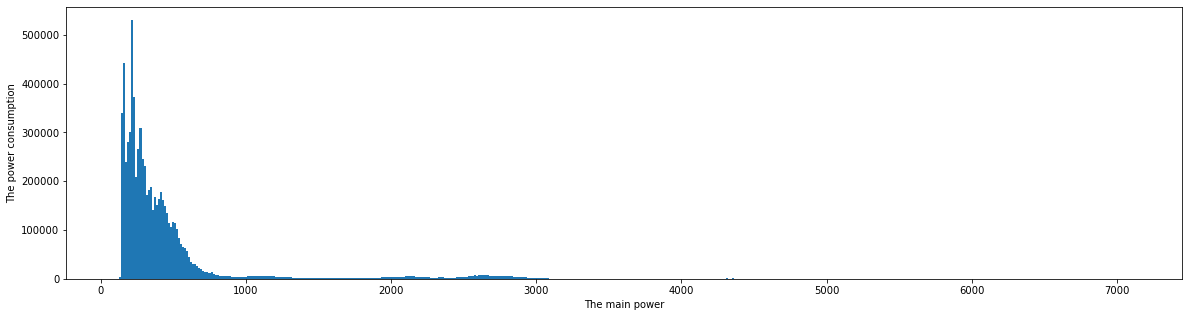

In [12]:
figure(figsize=(20,5))
_ = plt.hist(df_main['active_power'].values, bins=500)
plt.xlabel('The main power')
plt.ylabel('The power consumption')

## Customising the pipeline

### Custom pre-processing

In [16]:
def custom_preprocess(mains, hparams, submains=None):
    """
    Preprocess the main data using normalization
    :param mains: the aggregate power
    :param submains: the power of appliances
    :return: pd.DataFrame, pd.DataFrame, dict
    """
    # remove outliers
    if submains:
        for i in range(len(mains)):
            mains[i][mains[i]>5000] = 5000
        new_submains = []
        for val in submains:
            app, power = val
            new_powers = []
            for p in power:
                p[p>2500]=2500
                new_powers.append(new_powers)
            new_submains.append((app, new_powers))
    else:
        mains[mains>5000] = 5000
        
    # continue on the default pre-processing
    return  preprocess(mains,  hparams['input_norm'], submains)
        

## custom model

The UNET-NILM is well-known disagrgegation model that caught some attention in 2020. During the current notebook, we will explore two main variants of this model. The first variant of this model relies on a seq2point training paradigm and teh second variant relies on the seq2quantile paradigm. 

In [17]:
custom_unet = NILMExperiment({
                "model_class": UNETNILM,
                "loader_class": GeneralDataLoader,
                "model_name": 'base_unet',
                'backend':'pytorch',
                'in_size': 121,
                'out_size':1,
                'custom_preprocess':custom_preprocess,
                'feature_type':'mains',
                'input_norm':'z-norm',
                'target_norm':'z-norm',
                'seq_type':'seq2point',
                'point_position':'mid_position',
                'learning_rate':10e-5,
                'max_nb_epochs': 1
                })
base_unet = NILMExperiment({
                "model_class": UNETNILM,
                "loader_class": GeneralDataLoader,
                "model_name": 'base_unet',
                'backend':'pytorch',
                'in_size': 121,
                'out_size':1,
                'custom_preprocess':None,
                'feature_type':'mains',
                'input_norm':'z-norm',
                'target_norm':'z-norm',
                'seq_type':'seq2point',
                'point_position':'mid_position',
                'learning_rate':10e-5,
                'max_nb_epochs': 1
                })

#### Experiment Definiton

In [18]:
template = ExperimentTemplate( data_path=DATA_PATH,
                 template_name='ukdale',
                 list_appliances=['washing machine'],
                 list_baselines_backends=[],
                 in_sequence=121,
                 out_sequence=1,
                 max_epochs=20)

template.extend_experiment({'custom_unet': custom_unet})
template.extend_experiment({'base_unet': base_unet})

In [19]:
template.__print__()

"
        The current experiment is based on template ukdale
        Appliances ['washing machine']
        NILM MODELS ['custom_unet', 'base_unet']
        Dataset path ../../data/ukdale.h5
            - sampling rate :8
            - training data 
                - uses following buildings 1
                - uses following buildings 1
            - testing data
                - uses following buildings 1
        


In [ ]:
template.run_template(EXPERIMENT_NAME,
                     RESULTS_PATH,
                     f'{RESULTS_PATH}/mlflow')

run unet_with_baselines
Started training for  base_unet
Joint training for  base_unet
............... Loading Data for training ...................
Loading data for  ukdale  dataset
Loading building ...  1
Dropping missing values


2022/03/12 06:56:37 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of pytorch. If you encounter errors during autologging, try upgrading / downgrading pytorch to a supported version, or try upgrading MLflow.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


<class 'deep_nilmtk.models.pytorch.unet_nilm.UNETNILM'>



  | Name  | Type     | Params
-----------------------------------
0 | model | UNETNILM | 129 K 
-----------------------------------
129 K     Trainable params
0         Non-trainable params
129 K     Total params
0.517     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]                                                                                           

2022/03/12 06:56:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 49200bb4935b4316a9e055d7e5bf38e4. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'weight_decay\' was already logged with value=\'0.0\' for run ID=\'49200bb4935b4316a9e055d7e5bf38e4\'. Attempted logging new value \'0\'."))]')]


Epoch 0:  85%|███████████████████████████████████▋      | 12183/14333 [04:28<00:47, 45.36it/s, loss=0.0694, v_num=ent0]
Validating: 0it [00:00, ?it/s]
Epoch 0:  91%|██████████████████████████████████████    | 12987/14333 [04:35<00:28, 47.12it/s, loss=0.0694, v_num=ent0]


Epoch 0:  95%|████████████████████████████████████████  | 13673/14333 [04:41<00:13, 48.59it/s, loss=0.0694, v_num=ent0]


The aschived results are interesting. The MAE and the RMSE error looks good but the f1-score is a bit low. The generated predictions need to be more investiagted and observed as well as the details from the training 

## Plotting the generated predictions

In [3]:
import pickle

with open('C:/Users/Hafsa/Documents/test_notebooks/unet_nilm_experiment.p', 'rb') as file:
    results = pickle.load(file)
    
results.keys()

In [5]:
_,  true_consumption = results['test_submeters'][0]
pred_consumption = results['predictions']['UNET']

In [6]:
df_wm = pd.DataFrame({
    'true_consumption': true_consumption[0].values.reshape(-1), 
    'predicted_consumption': pred_consumption.values.reshape(-1),
}, index= true_consumption[0].index)

Text(0.5, 0, 'Time')

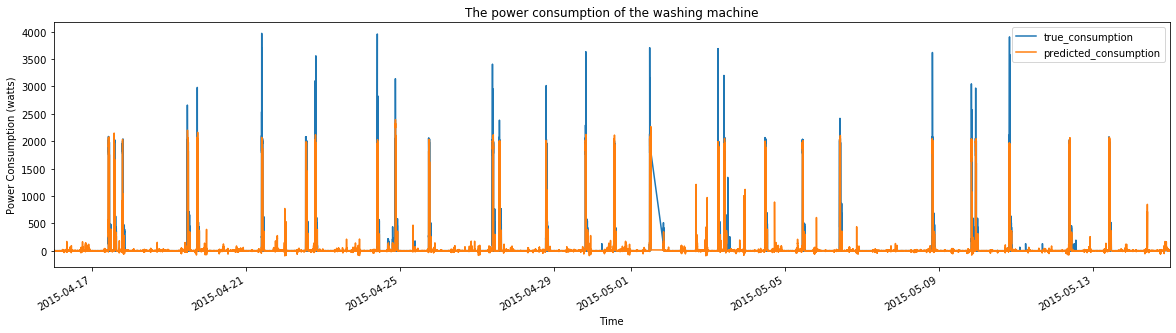

In [7]:
df_wm.plot(figsize=(20,5))
plt.title('The power consumption of the washing machine')
plt.ylabel('Power Consumption (watts)')
plt.xlabel('Time')

The previous plot shows that even though the UNET was trained only for few epochs. It is able to detect the correct values of the power consumption in the case of the washing machine which justifies the obtained values of the rmse and mae.

On the other hand, it seems that the model is correctly identifying the activations of the washing machine but recorded f1-score was low. Let's zoom on the predictions for more investigations.

Text(0.5, 0, 'Time')

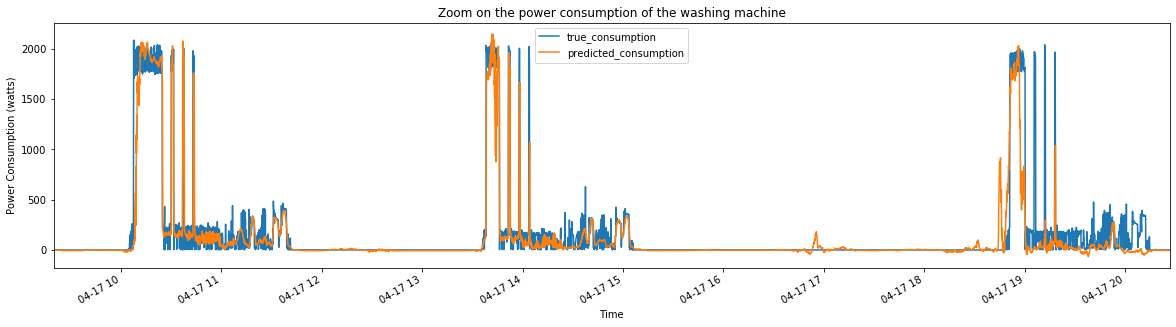

In [8]:
df_wm.iloc[15000:20000].plot(figsize=(20,5))
plt.title('Zoom on the power consumption of the washing machine')
plt.ylabel('Power Consumption (watts)')
plt.xlabel('Time')

The predictions seem to be correctly detecting the activations. The problem could be related to small noise generated. 

The f1-score as implemented in the NILMtk considers a standard threshold of 10 watts for all the appliances. However, this is would be mis-leading as a value of 15 or 20 watts from the consumption of the washing machine could be due to some noise/error generated during measurements. Let's try to estimate this value using a bigger threshold threshold.

In [9]:
from sklearn.metrics import f1_score as f1

f1_score = []

for i in range(2000):
    f1_score.append({
        'threshold': i,
        'f1-score': f1(
            1 * (df_wm['true_consumption'].values>i),
            1 * (df_wm['predicted_consumption'].values>i)
        )
    })

df_f1 = pd.DataFrame(f1_score)

Text(0, 0.5, 'f1-score')

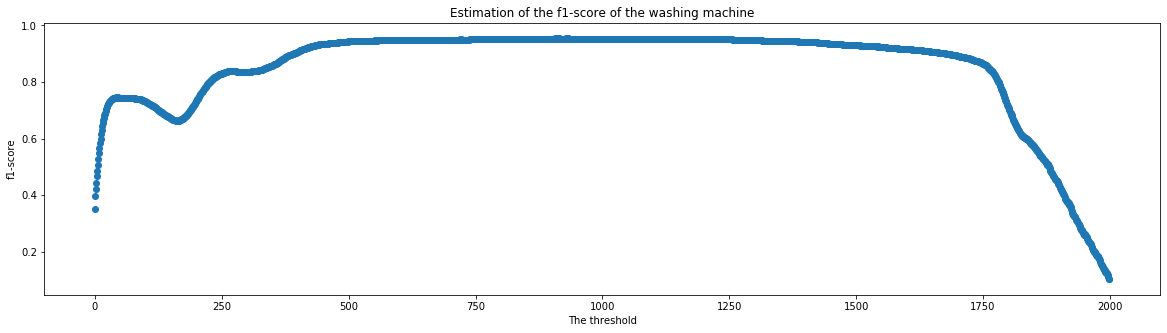

In [15]:
from matplotlib.pyplot import figure
figure(figsize=(20,5))
plt.scatter(x= df_f1['threshold'], y = df_f1['f1-score'])
plt.title('Estimation of the f1-score of the washing machine')
plt.xlabel('The threshold')
plt.ylabel('f1-score')

As it can be seen, the f1-score changes according to the threshold. However, it seems that a threshold between 500 and 1200 watts provide a stable f1-metric for the washing machine which is logical considering the characteristics of the washing machine. This of course should also be confirmed using different models.